In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch


In [3]:
try:
    from transformers import AutoTokenizer, AutoModel
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    print("⚠️  transformers not installed. Install with: pip install transformers")
    TRANSFORMERS_AVAILABLE = False



In [4]:
class TFIDFSentenceRanker:
    """Rank sentences by importance using TF-IDF"""

    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            ngram_range=(1, 2)
        )

    def rank_sentences(self, text, top_n=5):
        """Extract most important sentences using TF-IDF"""
        # Split into sentences
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if len(s.strip()) > 10]

        if len(sentences) == 0:
            return []

        try:
            tfidf_matrix = self.vectorizer.fit_transform(sentences)
            sentence_scores = np.array(tfidf_matrix.sum(axis=1)).flatten()
            top_indices = sentence_scores.argsort()[-top_n:][::-1]

            ranked_sentences = [
                {
                    'sentence': sentences[i],
                    'score': sentence_scores[i],
                    'position': i
                }
                for i in sorted(top_indices)
            ]

            return ranked_sentences
        except:
            return [
                {
                    'sentence': sentences[i],
                    'score': 1.0,
                    'position': i
                }
                for i in range(min(top_n, len(sentences)))
            ]

    def get_key_terms(self, text, top_n=10):
        """Extract most important terms using TF-IDF"""
        try:
            tfidf_matrix = self.vectorizer.fit_transform([text])
            feature_names = self.vectorizer.get_feature_names_out()
            tfidf_scores = tfidf_matrix.toarray()[0]

            top_indices = tfidf_scores.argsort()[-top_n:][::-1]
            key_terms = [
                {
                    'term': feature_names[i],
                    'score': tfidf_scores[i]
                }
                for i in top_indices if tfidf_scores[i] > 0
            ]

            return key_terms
        except:
            return []

In [5]:
class MedicalNER:
    """Named Entity Recognition for medical terms"""

    def __init__(self, model_name="dmis-lab/biobert-v1.1"):
        """Initialize BioBERT model for medical NER"""
        self.model = None

        if TRANSFORMERS_AVAILABLE:
            try:
                print(f"Loading BioBERT model: {model_name}")
                print("(This may take a minute on first run...)")

                self.tokenizer = AutoTokenizer.from_pretrained(model_name)
                self.model = AutoModel.from_pretrained(model_name)
                self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                self.model.to(self.device)
                print(f"✓ Model loaded on {self.device}\n")
            except Exception as e:
                print(f"Warning: Could not load BioBERT model: {e}")
                print("Using rule-based extraction instead\n")
        else:
            print("Using rule-based extraction (transformers not installed)\n")

    def extract_medical_entities(self, text):
        """Extract medical entities"""

        # Define medical entity categories with keywords
        medical_patterns = {
            'symptoms': ['pain', 'fever', 'cough', 'nausea', 'fatigue', 'headache',
                        'dizziness', 'vomiting', 'shortness of breath', 'ache'],
            'conditions': ['diabetes', 'hypertension', 'asthma', 'infection',
                          'pneumonia', 'disease', 'syndrome', 'disorder'],
            'medications': ['aspirin', 'ibuprofen', 'acetaminophen', 'antibiotic',
                          'insulin', 'medication', 'drug', 'prescription', 'mg'],
            'procedures': ['surgery', 'examination', 'test', 'scan', 'xray',
                          'ultrasound', 'biopsy', 'procedure'],
        }

        entities = {key: [] for key in medical_patterns.keys()}

        # Split text into chunks
        sentences = re.split(r'[.!?]+', text)

        for sentence in sentences:
            sentence = sentence.strip()
            if len(sentence) < 5:
                continue

            # Check each category
            for category, keywords in medical_patterns.items():
                for keyword in keywords:
                    if keyword.lower() in sentence.lower():
                        # Extract context around keyword
                        words = sentence.split()
                        for i, word in enumerate(words):
                            if keyword.lower() in word.lower():
                                # Get 2 words before and after
                                start = max(0, i-2)
                                end = min(len(words), i+3)
                                phrase = ' '.join(words[start:end])
                                if phrase not in entities[category]:
                                    entities[category].append(phrase)

        return entities


In [6]:
class MLMedicalSummarizer:
    """Complete ML-enhanced medical note summarizer"""

    def __init__(self):
        print("=" * 60)
        print("Initializing ML Medical Summarizer...")
        print("=" * 60)

        self.tfidf_ranker = TFIDFSentenceRanker()
        self.ner = MedicalNER()

        # Medical abbreviations dictionary
        self.abbreviations = {
            'pt': 'patient', 'pts': 'patients',
            'c/o': 'complains of', 'w/': 'with', 'w/o': 'without',
            'hx': 'history', 'h/o': 'history of',
            'dx': 'diagnosis', 'tx': 'treatment', 'rx': 'prescription',
            'sx': 'symptoms', 'fx': 'fracture',
            'n/v': 'nausea and vomiting', 'sob': 'shortness of breath',
            'cp': 'chest pain', 'abd': 'abdominal', 'ha': 'headache',
            'bp': 'blood pressure', 'hr': 'heart rate', 'rr': 'respiratory rate',
            'temp': 'temperature', 'wt': 'weight', 'ht': 'height',
            'yo': 'year old', 'yom': 'year old male', 'yof': 'year old female',
            'wnl': 'within normal limits', 'nad': 'no acute distress',
            'nkda': 'no known drug allergies',
        }

        # Section keywords
        self.section_keywords = {
            'chief_complaint': ['presents', 'complains', 'chief complaint', 'cc'],
            'symptoms': ['pain', 'fever', 'cough', 'nausea', 'vomiting', 'fatigue',
                        'denies', 'reports', 'states', 'describes'],
            'history': ['history', 'past medical', 'pmh', 'surgical history'],
            'medications': ['medication', 'drug', 'taking', 'prescribed', 'mg', 'daily'],
            'physical_exam': ['exam', 'examination', 'physical', 'vital signs', 'vitals',
                            'bp', 'hr', 'temp', 'appears', 'auscultation'],
            'assessment': ['assessment', 'impression', 'diagnosis', 'likely', 'differential'],
            'plan': ['plan', 'treatment', 'follow up', 'return', 'prescribed', 'advised']
        }

        print("✓ ML Summarizer ready!\n")

    def clean_text(self, text):
        """Clean and expand abbreviations"""
        text = text.lower()

        # Expand abbreviations
        for abbr, full in self.abbreviations.items():
            text = re.sub(r'\b' + re.escape(abbr) + r'\b', full, text)

        # Clean extra spaces
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def categorize_sentence(self, sentence):
        """Categorize sentence using keyword matching"""
        sentence_lower = sentence.lower()
        scores = {category: 0 for category in self.section_keywords.keys()}

        for category, keywords in self.section_keywords.items():
            for keyword in keywords:
                if keyword in sentence_lower:
                    scores[category] += 1

        # Return category with highest score
        max_category = max(scores, key=scores.get)
        return max_category if scores[max_category] > 0 else 'other'

    def generate_ml_summary(self, text, use_tfidf=True):
        """Generate summary using ML techniques"""
        # Step 1: Clean text
        cleaned_text = self.clean_text(text)

        # Step 2: Rank sentences by importance
        if use_tfidf:
            ranked_sentences = self.tfidf_ranker.rank_sentences(cleaned_text, top_n=10)
            sentences_to_use = [item['sentence'] for item in ranked_sentences]
        else:
            sentences_to_use = re.split(r'[.!?]+', cleaned_text)
            sentences_to_use = [s.strip() for s in sentences_to_use if len(s.strip()) > 10]

        # Step 3: Categorize sentences
        categorized = {category: [] for category in self.section_keywords.keys()}
        categorized['other'] = []

        for sentence in sentences_to_use:
            category = self.categorize_sentence(sentence)
            categorized[category].append(sentence)

        # Step 4: Extract medical entities
        entities = self.ner.extract_medical_entities(text)

        # Step 5: Generate structured output
        summary = self._format_summary(categorized, entities)

        return summary, categorized, entities

    def _format_summary(self, categorized, entities):
        """Format categorized sentences into readable summary"""
        summary = []
        summary.append("=" * 60)
        summary.append("ML-ENHANCED CLINICAL NOTE SUMMARY")
        summary.append("=" * 60)
        summary.append("")

        # Define order of sections
        section_order = [
            ('chief_complaint', 'CHIEF COMPLAINT'),
            ('symptoms', 'SYMPTOMS'),
            ('history', 'MEDICAL HISTORY'),
            ('medications', 'MEDICATIONS'),
            ('physical_exam', 'PHYSICAL EXAMINATION'),
            ('assessment', 'ASSESSMENT'),
            ('plan', 'PLAN')
        ]

        for key, title in section_order:
            if categorized.get(key) and len(categorized[key]) > 0:
                summary.append(title)
                summary.append("-" * 60)
                for sentence in categorized[key]:
                    summary.append(f"  • {sentence.capitalize()}")
                summary.append("")

        # Add extracted entities
        if any(entities.values()):
            summary.append("EXTRACTED MEDICAL ENTITIES")
            summary.append("-" * 60)
            for entity_type, entity_list in entities.items():
                if entity_list:
                    summary.append(f"  {entity_type.upper()}:")
                    for entity in entity_list[:5]:
                        summary.append(f"    - {entity}")
            summary.append("")

        return '\n'.join(summary)



In [7]:
class SummaryEvaluator:
    """Evaluate summary quality"""

    def calculate_metrics(self, original_text, summary_text):
        """Calculate basic evaluation metrics"""

        # Compression ratio
        compression_ratio = len(summary_text) / len(original_text) if len(original_text) > 0 else 0

        # Sentence count
        original_sentences = len(re.split(r'[.!?]+', original_text))
        summary_sentences = len(re.split(r'[.!?]+', summary_text))

        # Word count
        original_words = len(original_text.split())
        summary_words = len(summary_text.split())

        metrics = {
            'compression_ratio': compression_ratio,
            'original_sentences': original_sentences,
            'summary_sentences': summary_sentences,
            'original_words': original_words,
            'summary_words': summary_words,
            'reduction_percentage': (1 - compression_ratio) * 100
        }

        return metrics

    def print_metrics(self, metrics):
        """Print evaluation metrics"""
        print("\n" + "=" * 60)
        print("SUMMARY EVALUATION METRICS")
        print("=" * 60)
        print(f"Compression Ratio: {metrics['compression_ratio']:.2f}")
        print(f"Reduction: {metrics['reduction_percentage']:.1f}%")
        print(f"Original: {metrics['original_sentences']} sentences, {metrics['original_words']} words")
        print(f"Summary: {metrics['summary_sentences']} sentences, {metrics['summary_words']} words")
        print("=" * 60)


In [8]:
def visualize_ml_results(summarizer, patient_notes_df, num_samples=50):
    """Visualize ML summarization results"""

    print(f"\nAnalyzing {num_samples} notes...")

    results = {
        'sentence_counts': [],
        'entity_counts': [],
        'section_distributions': {section: [] for section in summarizer.section_keywords.keys()}
    }

    for i in range(min(num_samples, len(patient_notes_df))):
        note = patient_notes_df['pn_history'].iloc[i]

        try:
            summary, categorized, entities = summarizer.generate_ml_summary(note)

            total_sentences = sum(len(sents) for sents in categorized.values())
            results['sentence_counts'].append(total_sentences)

            total_entities = sum(len(ents) for ents in entities.values())
            results['entity_counts'].append(total_entities)

            for section, sentences in categorized.items():
                results['section_distributions'][section].append(len(sentences))
        except:
            continue

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('ML Summarizer Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Sentence count distribution
    axes[0, 0].hist(results['sentence_counts'], bins=20, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Summary Lengths')
    axes[0, 0].set_xlabel('Number of Sentences')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Plot 2: Entity extraction counts
    axes[0, 1].hist(results['entity_counts'], bins=20, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Medical Entities Extracted per Note')
    axes[0, 1].set_xlabel('Number of Entities')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Plot 3: Section distribution
    section_means = {k: np.mean(v) if v else 0 for k, v in results['section_distributions'].items()}
    sections = list(section_means.keys())
    means = list(section_means.values())

    axes[1, 0].barh(sections, means, color='lightgreen', edgecolor='black')
    axes[1, 0].set_title('Average Sentences per Section')
    axes[1, 0].set_xlabel('Average Number of Sentences')
    axes[1, 0].grid(axis='x', alpha=0.3)

    # Plot 4: Summary statistics
    stats_text = f"""
    ML SUMMARIZER STATISTICS
    ========================

    Notes Analyzed: {len(results['sentence_counts'])}

    Average Summary Length:
      {np.mean(results['sentence_counts']):.1f} sentences

    Average Entities Extracted:
      {np.mean(results['entity_counts']):.1f} entities

    Most Common Section:
      {max(section_means, key=section_means.get)}
    """

    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11,
                    verticalalignment='center', fontfamily='monospace')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return results



In [9]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Run complete ML pipeline"""

    print("\n" + "=" * 60)
    print("NBME ML MEDICAL NOTE SUMMARIZER")
    print("=" * 60)
    print()

    # Load data
    print("Loading NBME dataset...")
    try:
        # UPDATE THESE PATHS TO MATCH YOUR DATA LOCATION
        features_df = pd.read_csv('../../data/raw/nbme-score-clinical-patient-notes/features.csv')
        patient_notes_df = pd.read_csv('../../data/raw/nbme-score-clinical-patient-notes/patient_notes.csv')
        train_df = pd.read_csv('../../data/raw/nbme-score-clinical-patient-notes/train.csv')
        print(f"✓ Loaded {len(patient_notes_df)} patient notes\n")
    except FileNotFoundError as e:
        print(f"Error: Could not find data files: {e}")
        print("Please update the file paths in the main() function.")
        return None

    # Initialize ML summarizer
    summarizer = MLMedicalSummarizer()
    evaluator = SummaryEvaluator()

    # Test on sample note
    print("=" * 60)
    print("TESTING ML SUMMARIZER ON SAMPLE NOTE")
    print("=" * 60)
    print()

    sample_note = patient_notes_df['pn_history'].iloc[0]

    print("ORIGINAL NOTE:")
    print("-" * 60)
    print(sample_note[:500] + "..." if len(sample_note) > 500 else sample_note)
    print()

    # Generate ML summary
    print("GENERATING ML SUMMARY...")
    print()
    ml_summary, categorized, entities = summarizer.generate_ml_summary(sample_note)

    print(ml_summary)

    # Calculate metrics
    metrics = evaluator.calculate_metrics(sample_note, ml_summary)
    evaluator.print_metrics(metrics)

    # Show key terms
    print("\nKEY TERMS (TF-IDF):")
    print("-" * 60)
    key_terms = summarizer.tfidf_ranker.get_key_terms(sample_note, top_n=10)
    for i, term_info in enumerate(key_terms, 1):
        print(f"{i}. {term_info['term']} (score: {term_info['score']:.3f})")

    # Visualize results across dataset
    print("\n" + "=" * 60)
    print("ANALYZING DATASET (50 samples)...")
    print("=" * 60)

    results = visualize_ml_results(summarizer, patient_notes_df, num_samples=50)

    print("\n" + "=" * 60)
    print("NEXT STEPS FOR IMPROVEMENT:")
    print("=" * 60)
    print("1. ✓ Implemented TF-IDF sentence ranking")
    print("2. ✓ Added BioBERT for medical entity extraction")
    print("3. TODO: Fine-tune on NBME training data")
    print("4. TODO: Add abstractive summarization (T5/BART)")
    print("5. TODO: Implement ROUGE evaluation metrics")
    print("6. TODO: Create patient-friendly language converter")
    print("=" * 60)
    print()

    return summarizer, evaluator, patient_notes_df



🚀 Starting NBME ML Summarizer...


NBME ML MEDICAL NOTE SUMMARIZER

Loading NBME dataset...
✓ Loaded 42146 patient notes

Initializing ML Medical Summarizer...
Loading BioBERT model: dmis-lab/biobert-v1.1
(This may take a minute on first run...)
✓ Model loaded on cpu

✓ ML Summarizer ready!

TESTING ML SUMMARIZER ON SAMPLE NOTE

ORIGINAL NOTE:
------------------------------------------------------------
17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment
-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav
-associated with dispnea on exersion and rest,stressed out about school
-reports fe feels like his heart is jumping out of his chest
-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal ed...

GENERATING ML SUMMARY...

ML-ENHANCED CLINICAL NOTE SUMMARY

SYMPTOMS
---------------------

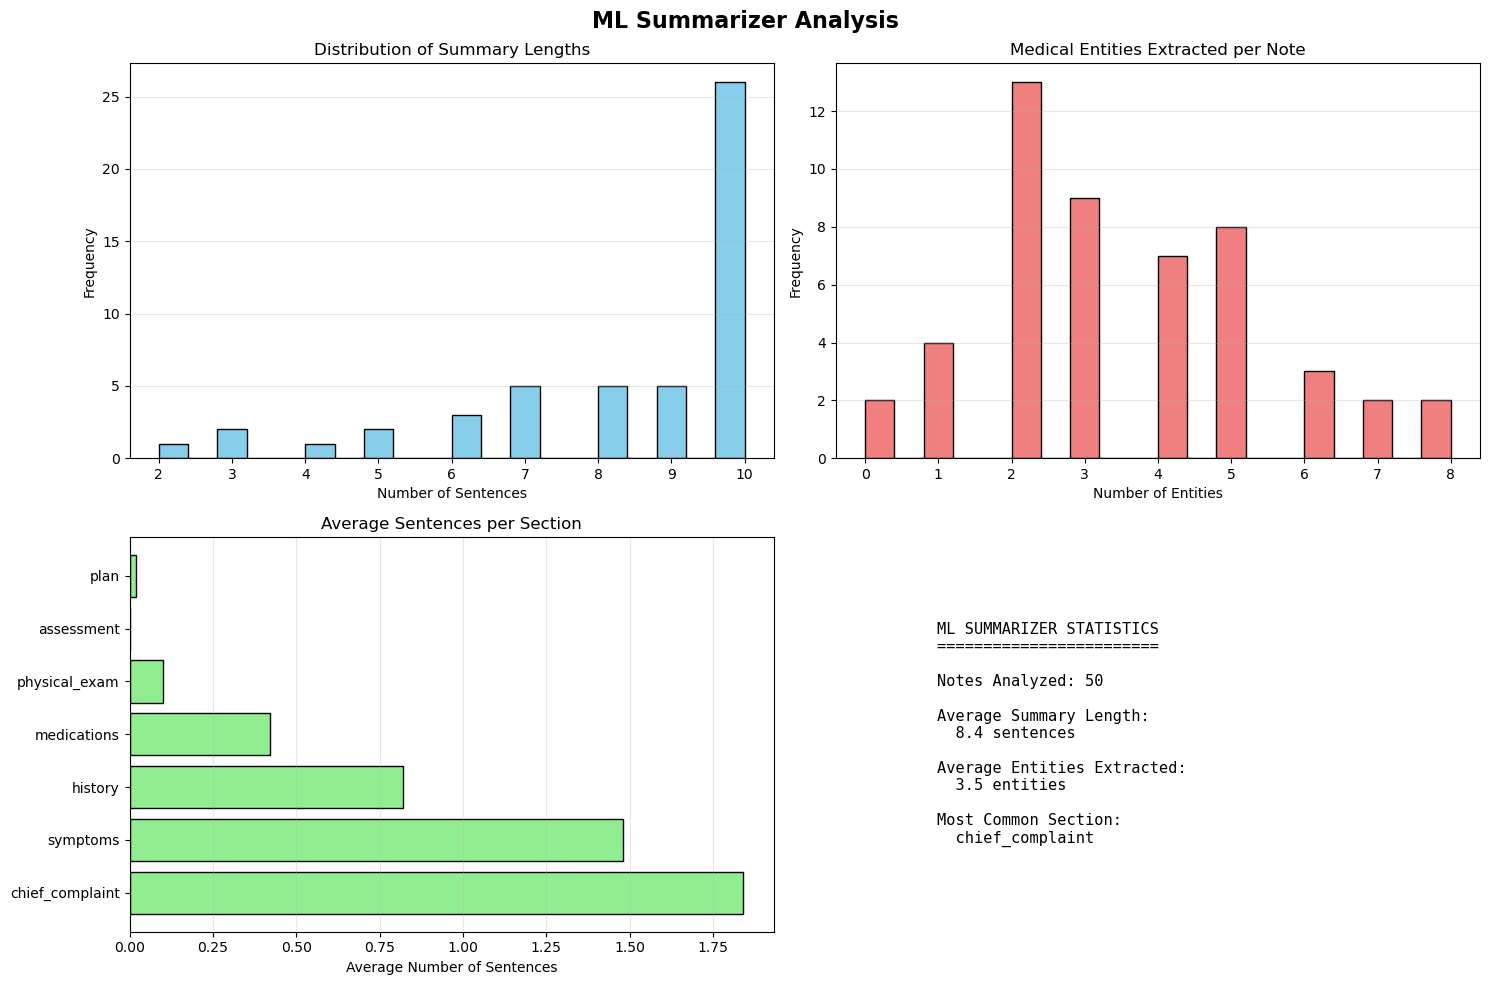


NEXT STEPS FOR IMPROVEMENT:
1. ✓ Implemented TF-IDF sentence ranking
2. ✓ Added BioBERT for medical entity extraction
3. TODO: Fine-tune on NBME training data
4. TODO: Add abstractive summarization (T5/BART)
5. TODO: Implement ROUGE evaluation metrics
6. TODO: Create patient-friendly language converter


✓ Pipeline completed successfully!

You can now use:
  - summarizer.generate_ml_summary(text)
  - evaluator.calculate_metrics(original, summary)


In [10]:
# =============================================================================
# RUN THE SCRIPT
# =============================================================================

if __name__ == "__main__":
    print("\n🚀 Starting NBME ML Summarizer...\n")

    # Run the main pipeline
    result = main()

    if result:
        summarizer, evaluator, patient_notes_df = result
        print("\n✓ Pipeline completed successfully!")
        print("\nYou can now use:")
        print("  - summarizer.generate_ml_summary(text)")
        print("  - evaluator.calculate_metrics(original, summary)")
    else:
        print("\n❌ Pipeline failed. Please check your data paths.")

In [11]:
import pandas as pd
import numpy as np
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import re
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import time
from datetime import datetime
import os

In [12]:
!pip install sentencepiece

In [12]:
class BatchAbstractiveSummarizer:
    """Generate abstractive summaries for entire dataset"""

    def __init__(self, model_name='t5-small', device=None):
        """Initialize summarizer"""
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model_name = model_name

        print(f"Loading {model_name}...")
        print(f"Device: {self.device}")

        # Load model and tokenizer
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

        print("✓ Model loaded successfully!\n")

    def summarize_single(self, text, max_length=150, min_length=40,
                        num_beams=4, length_penalty=2.0):
        """Generate summary for a single note"""
        try:
            # Preprocess
            text = self._preprocess_text(text)
            text = "summarize: " + text

            # Tokenize
            inputs = self.tokenizer.encode(
                text,
                return_tensors='pt',
                max_length=512,
                truncation=True
            ).to(self.device)

            # Generate
            with torch.no_grad():
                summary_ids = self.model.generate(
                    inputs,
                    max_length=max_length,
                    min_length=min_length,
                    num_beams=num_beams,
                    length_penalty=length_penalty,
                    early_stopping=True
                )

            # Decode
            summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
            return summary

        except Exception as e:
            print(f"Error summarizing: {e}")
            return "[Error: Could not generate summary]"

    def _preprocess_text(self, text):
        """Clean text before summarization"""
        # Convert to string
        text = str(text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Limit length
        words = text.split()
        if len(words) > 400:
            text = ' '.join(words[:400])

        return text

    def process_all_notes(self, patient_notes_df,
                         output_file='../../data/processed/abstractive_summaries.csv',
                         batch_size=10,
                         save_frequency=50,
                         resume_from=None):
        """
        Process all notes and save to CSV

        Args:
            patient_notes_df: DataFrame with patient notes
            output_file: Path to save results
            batch_size: Process this many at once
            save_frequency: Save progress every N records
            resume_from: Row number to resume from (if interrupted)

        Returns:
            DataFrame with original notes + summaries
        """
        print("=" * 70)
        print("BATCH ABSTRACTIVE SUMMARY GENERATION")
        print("=" * 70)
        print(f"Total notes to process: {len(patient_notes_df)}")
        print(f"Output file: {output_file}")
        print(f"Model: {self.model_name}")
        print(f"Device: {self.device}")
        print("=" * 70)
        print()

        # Create output directory if it doesn't exist
        output_dir = os.path.dirname(output_file)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created directory: {output_dir}")

        # Check if we're resuming
        start_idx = 0
        if resume_from and os.path.exists(output_file):
            print(f"Resuming from row {resume_from}...")
            existing_df = pd.read_csv(output_file)
            start_idx = resume_from
            results_df = existing_df.copy()
        else:
            # Create results DataFrame
            results_df = patient_notes_df.copy()
            results_df['abstractive_summary'] = ''
            results_df['summary_length'] = 0
            results_df['compression_ratio'] = 0.0
            results_df['processing_time'] = 0.0
            results_df['timestamp'] = ''

        # Process in batches with progress bar
        total_notes = len(patient_notes_df)

        with tqdm(total=total_notes, initial=start_idx, desc="Generating summaries") as pbar:
            for idx in range(start_idx, total_notes):
                start_time = time.time()

                # Get note
                note_text = patient_notes_df.iloc[idx]['pn_history']
                pn_num = patient_notes_df.iloc[idx]['pn_num']

                # Generate summary
                summary = self.summarize_single(note_text)

                # Calculate metrics
                processing_time = time.time() - start_time
                compression_ratio = len(summary) / len(note_text) if len(note_text) > 0 else 0

                # Store results
                results_df.at[idx, 'abstractive_summary'] = summary
                results_df.at[idx, 'summary_length'] = len(summary)
                results_df.at[idx, 'compression_ratio'] = compression_ratio
                results_df.at[idx, 'processing_time'] = processing_time
                results_df.at[idx, 'timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

                # Update progress bar
                pbar.update(1)
                pbar.set_postfix({
                    'pn_num': pn_num,
                    'time': f'{processing_time:.2f}s',
                    'ratio': f'{compression_ratio:.2f}'
                })

                # Save progress periodically
                if (idx + 1) % save_frequency == 0:
                    results_df.to_csv(output_file, index=False)
                    pbar.write(f"✓ Progress saved at row {idx + 1}")

        # Final save
        results_df.to_csv(output_file, index=False)

        print("\n" + "=" * 70)
        print("PROCESSING COMPLETE!")
        print("=" * 70)
        print(f"✓ Processed {total_notes} notes")
        print(f"✓ Results saved to: {output_file}")

        # Print summary statistics
        self._print_statistics(results_df)

        return results_df

    def _print_statistics(self, results_df):
        """Print summary statistics"""
        print("\n" + "=" * 70)
        print("SUMMARY STATISTICS")
        print("=" * 70)

        avg_original_length = results_df['pn_history'].str.len().mean()
        avg_summary_length = results_df['summary_length'].mean()
        avg_compression = results_df['compression_ratio'].mean()
        avg_time = results_df['processing_time'].mean()
        total_time = results_df['processing_time'].sum()

        print(f"Average original note length: {avg_original_length:.0f} characters")
        print(f"Average summary length: {avg_summary_length:.0f} characters")
        print(f"Average compression ratio: {avg_compression:.2f}")
        print(f"Average processing time: {avg_time:.2f} seconds/note")
        print(f"Total processing time: {total_time/60:.1f} minutes")
        print("=" * 70)

    def process_sample(self, patient_notes_df, n_samples=10,
                      output_file='../../data/processed/sample_summaries.csv'):
        """Process just a sample for testing"""
        print(f"Processing {n_samples} sample notes...")
        sample_df = patient_notes_df.head(n_samples)
        return self.process_all_notes(sample_df, output_file, save_frequency=5)


def load_and_preview_summaries(file_path):
    """Load generated summaries and show preview"""
    print(f"\nLoading summaries from: {file_path}")

    df = pd.read_csv(file_path)

    print("\n" + "=" * 70)
    print("LOADED SUMMARIES")
    print("=" * 70)
    print(f"Total records: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print("\n" + "=" * 70)
    print("SAMPLE SUMMARIES (First 3)")
    print("=" * 70)

    for idx in range(min(3, len(df))):
        print(f"\n--- Record {idx + 1} ---")
        print(f"Patient Note #: {df.iloc[idx]['pn_num']}")
        print(f"\nOriginal Note (first 200 chars):")
        print(df.iloc[idx]['pn_history'][:200] + "...")
        print(f"\nAbstractive Summary:")
        print(df.iloc[idx]['abstractive_summary'])
        print(f"\nMetrics:")
        print(f"  Compression Ratio: {df.iloc[idx]['compression_ratio']:.2f}")
        print(f"  Summary Length: {df.iloc[idx]['summary_length']} characters")
        print(f"  Processing Time: {df.iloc[idx]['processing_time']:.2f} seconds")
        print("-" * 70)

    return df


In [13]:
def main():
    """Main execution"""

    print("\n" + "=" * 70)
    print("BATCH ABSTRACTIVE SUMMARIZATION PIPELINE")
    print("=" * 70)
    print()

    # Load data
    print("Loading NBME dataset...")
    try:
        patient_notes_df = pd.read_csv('../../data/raw/nbme-score-clinical-patient-notes/patient_notes.csv')
        print(f"✓ Loaded {len(patient_notes_df)} patient notes\n")
    except FileNotFoundError as e:
        print(f"Error: Could not find data file: {e}")
        print("Please update the file path.")
        return None

    # Initialize summarizer
    summarizer = BatchAbstractiveSummarizer(model_name='t5-small')

    # Ask user what they want to do
    print("=" * 70)
    print("CHOOSE PROCESSING MODE:")
    print("=" * 70)
    print("1. Process SAMPLE (10 notes) - Quick test")
    print("2. Process SAMPLE (100 notes) - Medium test")
    print("3. Process ALL notes - Full dataset")
    print("=" * 70)

    # For notebook execution, we'll default to option 1
    # User can change this
    choice = 1  # Change this to 2 or 3 as needed

    if choice == 1:
        print("\n▶ Processing 10 sample notes...")
        results_df = summarizer.process_sample(
            patient_notes_df,
            n_samples=10,
            output_file='../../data/processed/sample_10_summaries.csv'
        )
        output_file = '../../data/processed/sample_10_summaries.csv'

    elif choice == 2:
        print("\n▶ Processing 100 sample notes...")
        results_df = summarizer.process_sample(
            patient_notes_df,
            n_samples=100,
            output_file='../../data/processed/sample_100_summaries.csv'
        )
        output_file = '../../data/processed/sample_100_summaries.csv'

    else:  # choice == 3
        print("\n▶ Processing ALL notes...")
        print("⚠️  This will take a while (several hours on CPU)")
        print("    The script will save progress every 50 notes")
        print("    You can stop and resume later if needed\n")

        results_df = summarizer.process_all_notes(
            patient_notes_df,
            output_file='../../data/processed/all_abstractive_summaries.csv',
            save_frequency=50
        )
        output_file = '../../data/processed/all_abstractive_summaries.csv'

    # Preview results
    print("\n" + "=" * 70)
    print("PREVIEWING RESULTS")
    print("=" * 70)
    df = load_and_preview_summaries(output_file)

    print("\n" + "=" * 70)
    print("✓ COMPLETE!")
    print("=" * 70)
    print(f"Your summaries are saved in: {output_file}")
    print("\nYou can load them later with:")
    print(f"  df = pd.read_csv('{output_file}')")
    print("=" * 70)

    return results_df, summarizer


In [14]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def resume_processing(checkpoint_file, patient_notes_df, resume_from_row):
    """Resume processing from a specific row"""
    print(f"Resuming processing from row {resume_from_row}...")

    summarizer = BatchAbstractiveSummarizer(model_name='t5-small')

    results_df = summarizer.process_all_notes(
        patient_notes_df,
        output_file=checkpoint_file,
        resume_from=resume_from_row
    )

    return results_df


def compare_summaries(results_df, note_index=0):
    """Compare original note with abstractive summary"""
    print("\n" + "=" * 70)
    print(f"COMPARISON - Note #{note_index}")
    print("=" * 70)

    row = results_df.iloc[note_index]

    print("\n📄 ORIGINAL NOTE:")
    print("-" * 70)
    print(row['pn_history'])

    print("\n\n✨ ABSTRACTIVE SUMMARY:")
    print("-" * 70)
    print(row['abstractive_summary'])

    print("\n\n📊 METRICS:")
    print("-" * 70)
    print(f"Original length: {len(row['pn_history'])} characters")
    print(f"Summary length: {row['summary_length']} characters")
    print(f"Compression ratio: {row['compression_ratio']:.2%}")
    print(f"Processing time: {row['processing_time']:.2f} seconds")
    print("=" * 70)


In [16]:
# Install missing dependency
#!pip install sentencepiece
!pip install transformers torch sentencepiece rouge-score tqdm

In [15]:
# =============================================================================
# RUN THE SCRIPT
# =============================================================================

if __name__ == "__main__":
    print("\n🚀 Starting Batch Summarization...\n")

    # Run main pipeline
    results_df, summarizer = main()

    # Show a detailed comparison
    if results_df is not None and len(results_df) > 0:
        print("\n\n📋 DETAILED EXAMPLE:")
        compare_summaries(results_df, note_index=0)


🚀 Starting Batch Summarization...


BATCH ABSTRACTIVE SUMMARIZATION PIPELINE

Loading NBME dataset...
✓ Loaded 42146 patient notes

Loading t5-small...
Device: cpu


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


✓ Model loaded successfully!

CHOOSE PROCESSING MODE:
1. Process SAMPLE (10 notes) - Quick test
2. Process SAMPLE (100 notes) - Medium test
3. Process ALL notes - Full dataset

▶ Processing 10 sample notes...
Processing 10 sample notes...
BATCH ABSTRACTIVE SUMMARY GENERATION
Total notes to process: 10
Output file: ../../data/processed/sample_10_summaries.csv
Model: t5-small
Device: cpu



Generating summaries:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 5/10 [00:09<00:09,  1.86s/it, pn_num=4, time=1.46s, ratio=0.22]

✓ Progress saved at row 5


Generating summaries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it, pn_num=9, time=1.25s, ratio=0.27]

✓ Progress saved at row 10

PROCESSING COMPLETE!
✓ Processed 10 notes
✓ Results saved to: ../../data/processed/sample_10_summaries.csv

SUMMARY STATISTICS
Average original note length: 768 characters
Average summary length: 220 characters
Average compression ratio: 0.30
Average processing time: 1.64 seconds/note
Total processing time: 0.3 minutes

PREVIEWING RESULTS

Loading summaries from: ../../data/processed/sample_10_summaries.csv

LOADED SUMMARIES
Total records: 10
Columns: ['pn_num', 'case_num', 'pn_history', 'abstractive_summary', 'summary_length', 'compression_ratio', 'processing_time', 'timestamp']

SAMPLE SUMMARIES (First 3)

--- Record 1 ---
Patient Note #: 0

Original Note (first 200 chars):
17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment
-began 2-3 mo...

Abstractive Summary:
the 17-year-old has come to the student health clinic complain